# Imports
pyabf reads your abf files, scipy contains your peak-finding functions, matplotlib makes pretty graphs, and pandas and numpy are essential packages

In [1]:
import pyabf
import efel
from scipy import nanmean
import pyabf.filter
import pyabf.tools.memtest
import pyabf.plot
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import os
from statistics import mean

C:\ProgramData\Anaconda3\lib\site-packages\pyabf\tools\memtest.py:21: UserWarning: The pyabf package is designed for reading ABF files (not analyzing them). This module is experimental, provided only for backwards compatibility, and its API may change in future releases. Users are encouraged to write their own ABF analysis code.
  warnings.warn("The pyabf package is designed for reading ABF files (not analyzing them). " +
C:\ProgramData\Anaconda3\lib\site-packages\pyabf\plot.py:14: UserWarning: abf.plot is obsolete and should not be used
  warnings.warn("abf.plot is obsolete and should not be used")


# Load your data and variables
Printing your abf will show you the file information (channels, sampling rate, number of sweeps, length of sweep window, protocol used)

In [2]:
#loads your clampfit data when you specify the file path
#the two dataframes created here will be later used to subtract the stim and nostim traces
data = r"C:\Users\Valerie\Downloads\VJUMP\VAL\2023_07_06_0001.abf"
abf = pyabf.ABF(data)
a = pd.DataFrame(list(range(0, 500)))
b = pd.DataFrame(list(range(0, 500)))

In [3]:
abf

ABF (v2.9) with 3 channels (pA, pA, V), sampled at 20.0 kHz, containing 90 sweeps, having no tags, with a total length of 15.10 minutes, recorded with protocol "VC_Voltage_JUMPER_0.1 Hz". path=C:\Users\Valerie\Downloads\VJUMP\VAL\2023_07_06_0001.abf

In [4]:
#these set of lists specify the grouping of sweeps we will be averaging for the conditions we're interested in 
#(ie, 'nostim' vs 'stim', 'baseline_stim' vs 'drug_bath_stim', etc.)
#change the numbers in a series based on what you're analyzing
#python indexes starting from 0, subtract 1 from every corresponding clampfit sweep number

nostim = list(range(0, 90, 2))
stim = list(range(1, 89, 2))

In [5]:
#for loop that loops through listed sweeps in nostim or stim lists
#appends recorded voltage for every datapoint between the specified timepoints 
#within a sweep to either the stim or no stim dataframes (a, b) 
for i, j in zip(stim, nostim):
    abf.setSweep(i)
    time = abf.sweepX*1000 # in miliseconds
    voltage = abf.sweepY
    sweep = pd.DataFrame(time)
    sweep = sweep.rename(columns={sweep.columns[0]: 'time'})
    sweep['voltage'] = voltage
    sweep = sweep[62250 : 62750]
    sweep.reset_index(inplace=True, drop=True)
    b['sweep_' + str(i)] = sweep['voltage']
    abf.setSweep(j)
    time = abf.sweepX*1000 # in miliseconds
    voltage = abf.sweepY
    sweep = pd.DataFrame(time)
    sweep = sweep.rename(columns={sweep.columns[0]: 'time'})
    sweep['voltage'] = voltage
    sweep = sweep[62250 : 62750]
    sweep.reset_index(inplace=True, drop=True)
    a['sweep_' + str(j)] = sweep['voltage']

In [6]:
#drops extra column in the dataframes, then averages voltage for a given timepoint across all sweeps
#subtracts averaged nostim voltage from stim and stores results in a new dataframe (subtracted)
#subtracted has 2 columns, one with 'time' (experimental time) and one with subtracted 'voltage'
a.drop(columns={a.columns[0]},inplace=True)
b.drop(columns={b.columns[0]},inplace=True)
a['sweep_mean'] = a.mean(axis=1) 
b['sweep_mean'] = b.mean(axis=1) 
subtracted = pd.DataFrame(list(range(0, 100)))
subtracted['time'] = sweep.time
subtracted['voltage'] = b.sweep_mean - a.sweep_mean

Text(0, 0.5, 'Current (pA)')

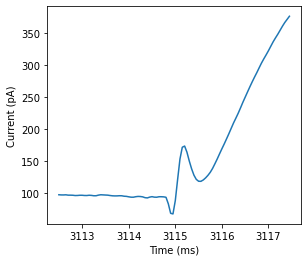

In [7]:
#plot subtracted trace
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.plot(subtracted.time, subtracted.voltage)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (pA)')
#ax1.set_ylim(-50, 100)

In [8]:
#use subtracted trace to 1. identify peak and 2. calculate latency using time between 10% and 90% of max amp of response
s = pd.Series(subtracted.voltage)
peak = s[s.argmax()]
trough = s[s.argmin()]
peak = peak - trough
rise = np.where(((subtracted.voltage - trough) > (peak * .9)))
start = np.where(((subtracted.voltage - trough) > (peak * .1)) & (subtracted.time > 3115))
rise_time = subtracted.time[rise[0][0] - 1]
start_time = subtracted.time[start[0][0] - 1]
risetime = rise_time - start_time
print(peak, risetime)

308.67072 2.150000000000091


In [9]:
a.drop(columns={a.columns[0]},inplace=True)
b.drop(columns={b.columns[0]},inplace=True)
subtracted = pd.DataFrame(list(range(0, 100)))

In [10]:
for i, j in zip(list(a.columns), list(b.columns)):
    subtracted['time'] = sweep.time
    subtracted[j + i + '_subtracted'] = b[j] - a[i]

Text(0, 0.5, 'Current (pA)')

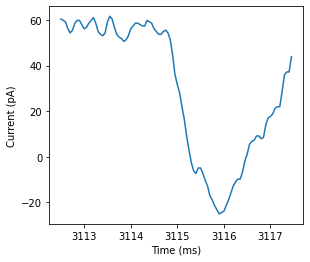

In [11]:
#plot subtracted trace
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.plot(subtracted.time, subtracted['sweep_81sweep_80_subtracted'])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (pA)')
#ax1.set_ylim(-50, 100)

In [12]:
subtracted

,0,time,sweep_3sweep_2_subtracted,sweep_5sweep_4_subtracted,sweep_7sweep_6_subtracted,sweep_9sweep_8_subtracted,sweep_11sweep_10_subtracted,sweep_13sweep_12_subtracted,sweep_15sweep_14_subtracted,sweep_17sweep_16_subtracted,...,sweep_71sweep_70_subtracted,sweep_73sweep_72_subtracted,sweep_75sweep_74_subtracted,sweep_77sweep_76_subtracted,sweep_79sweep_78_subtracted,sweep_81sweep_80_subtracted,sweep_83sweep_82_subtracted,sweep_85sweep_84_subtracted,sweep_87sweep_86_subtracted,sweep_meansweep_mean_subtracted
0,0,3112.50,195.922852,147.705078,131.225586,165.405273,97.045898,189.208984,147.705078,-56.152344,...,66.528320,43.334961,30.517578,50.659180,47.607422,60.424805,-40.893555,20.141602,-28.076172,97.434326
1,1,3112.55,195.312500,152.587891,129.394531,167.846680,95.825195,189.819336,146.484375,-58.593750,...,67.138672,45.776367,27.465820,51.269531,53.100586,59.814453,-38.452148,23.193359,-31.738281,97.170532
2,2,3112.60,202.636719,150.146484,129.394531,164.794922,93.994141,191.650391,144.042969,-60.424805,...,66.528320,45.776367,27.465820,51.879883,57.373047,59.204102,-35.400391,22.583008,-35.400391,97.129150
3,3,3112.65,199.584961,147.094727,130.004883,162.963867,95.825195,189.819336,138.549805,-57.983398,...,66.528320,46.997070,27.465820,51.879883,57.373047,56.152344,-32.958984,21.972656,-36.010742,97.351135
4,4,3112.70,194.702148,148.315430,128.173828,162.963867,95.825195,186.767578,136.108398,-55.541992,...,63.476562,46.386719,25.634766,49.438477,53.710938,54.321289,-29.907227,17.089844,-32.958984,96.809875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,3117.25,1024.780273,562.744141,552.978516,604.248047,567.016602,522.460938,611.572266,562.744141,...,230.102539,53.710938,157.470703,98.266602,40.893555,28.686523,51.879883,28.076172,38.452148,354.322876
96,96,3117.30,1038.818359,568.847656,562.744141,613.403320,573.730469,538.940430,619.506836,570.678711,...,233.764648,54.931641,159.912109,98.876953,42.114258,36.010742,48.828125,28.076172,36.621094,360.620697
97,97,3117.35,1049.804688,574.951172,571.899414,625.000000,585.327148,548.706055,626.220703,571.899414,...,238.037109,54.321289,165.405273,100.708008,43.334961,37.231445,51.269531,28.686523,37.841797,366.377380
98,98,3117.40,1060.791016,579.223633,581.665039,633.544922,595.092773,553.588867,631.713867,574.340820,...,243.530273,53.710938,166.015625,98.876953,43.945312,37.231445,53.100586,28.686523,42.114258,371.273987


In [13]:
rise_times = pd.DataFrame(list(range(0,44)))
sweeps = []
peaks = []
risetime = []

In [14]:
for i in list(subtracted.columns[2:46]):
    print(i)
    sweeps.append(i)
    s = pd.Series(subtracted[i])
    peak = s[s.argmax()]
    trough = s[s.argmin()]
    peak = peak - trough
    print(peak, trough)
    peaks.append(peak)
    rise = np.where(((subtracted[i] - trough) > (peak * .9)) & (subtracted.time > 3114))
    start = np.where(((subtracted[i] - trough) > (peak * .1)) & (subtracted.time > 3114))
    rise_time = subtracted.time[rise[0][0] - 1]
    start_time = subtracted.time[start[0][0] - 1]
    rise_time = rise_time - start_time
    risetime.append(rise_time)

sweep_3sweep_2_subtracted
1170.6543 -98.87695
sweep_5sweep_4_subtracted
505.3711 78.125
sweep_7sweep_6_subtracted
650.63477 -61.035156
sweep_9sweep_8_subtracted
551.14746 90.33203
sweep_11sweep_10_subtracted
553.58887 49.438477
sweep_13sweep_12_subtracted
479.12598 83.618164
sweep_15sweep_14_subtracted
532.8369 104.98047
sweep_17sweep_16_subtracted
791.626 -152.58789
sweep_19sweep_18_subtracted
415.6494 61.035156
sweep_21sweep_20_subtracted
477.90527 73.24219
sweep_23sweep_22_subtracted
537.1094 -83.00781
sweep_25sweep_24_subtracted
385.13184 103.149414
sweep_27sweep_26_subtracted
394.89746 62.25586
sweep_29sweep_28_subtracted
423.58398 106.20117
sweep_31sweep_30_subtracted
386.35254 100.09766
sweep_33sweep_32_subtracted
302.12402 60.424805
sweep_35sweep_34_subtracted
396.72852 33.569336
sweep_37sweep_36_subtracted
501.09863 -144.04297
sweep_39sweep_38_subtracted
366.21094 41.503906
sweep_41sweep_40_subtracted
352.17285 62.25586
sweep_43sweep_42_subtracted
294.18945 122.680664
sweep_45

In [15]:
rise_times['sweeps'] = sweeps
rise_times['peak'] = peaks
rise_times['risetime'] = risetime
rise_times

,0,sweeps,peak,risetime
0,0,sweep_3sweep_2_subtracted,1170.654297,1.15
1,1,sweep_5sweep_4_subtracted,505.371094,3.10
2,2,sweep_7sweep_6_subtracted,650.634766,3.10
3,3,sweep_9sweep_8_subtracted,551.147461,3.15
4,4,sweep_11sweep_10_subtracted,553.588867,3.05
5,5,sweep_13sweep_12_subtracted,479.125977,3.25
6,6,sweep_15sweep_14_subtracted,532.836914,2.05
7,7,sweep_17sweep_16_subtracted,791.625977,1.25
8,8,sweep_19sweep_18_subtracted,415.649414,2.10
9,9,sweep_21sweep_20_subtracted,477.905273,2.20


(6.0, 45.15)

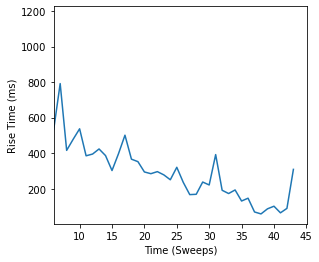

In [25]:
#plot subtracted trace
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.plot(rise_times[0], rise_times['peak'])
ax1.set_xlabel('Time (Sweeps)')
ax1.set_ylabel('Rise Time (ms)')
ax1.set_xlim(6,)
#ax1.set_ylim(0, 500)

In [157]:
def multiples(value, length):
    return [value * i for i in range(0, length + 1)]
bins = multiples(3,40)

In [158]:
len(b)

500

In [159]:
a = list(rise_times.groupby(pd.cut(rise_times[0],bins=bins))['peak'].mean())
b = list(range(0, 40))
abc = pd.DataFrame(a, b)

In [161]:
rise_times.to_csv(r'C:\Users\Valerie\Downloads\VJUMP\VAL\2023_07_06_0001_rise_times.csv')
abc.to_csv(r'C:\Users\Valerie\Downloads\VJUMP\VAL\2023_07_06_0001_binned.csv')

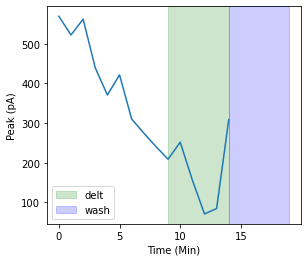

In [160]:
#plot subtracted trace
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.plot(b, a)
ax1.set_xlabel('Time (Min)')
ax1.set_ylabel('Peak (pA)')
ax1.axvspan(9, 14, label='delt', color='green', alpha=0.2)
ax1.axvspan(14, 19, label='wash', color='blue', alpha=0.2)
#ax1.axvspan(20, 30, label='ptx', color='yellow', alpha=0.2)
ax1.legend()
#ax1.set_ylim(0,500)

In [3]:
df = pd.read_csv(r'C:\Users\Valerie\Downloads\VJUMP\HEY\2023_06_30_0003_binned.csv')

In [18]:
bl = 7
bl_avg = (df[df.columns[1]].iloc[bl] + df[df.columns[1]].iloc[bl - 1])/2

In [19]:
df['bl_corrected'] = df[df.columns[1]]/bl_avg

In [21]:
df = df[(bl - 5):]
df.reset_index(inplace=True)
df.drop(columns = {'index', 'Unnamed: 0'}, inplace = True)

In [32]:
df = df.fillna(0)

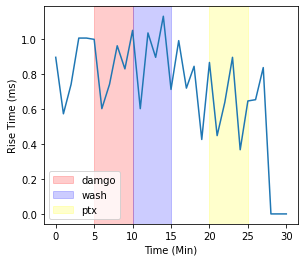

In [33]:
#plot subtracted trace
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.plot(df['bl_corrected'])
ax1.set_xlabel('Time (Min)')
ax1.set_ylabel('Rise Time (ms)')
ax1.axvspan(5, 10, label='damgo', color='red', alpha=0.2)
ax1.axvspan(10, 15, label='wash', color='blue', alpha=0.2)
ax1.axvspan(20, 25, label='ptx', color='yellow', alpha=0.2)
ax1.legend()
#ax1.set_xlim(0,25)